source: https://towardsdatascience.com/mnist-cnn-python-c61a5bce7a19

# Title

In [119]:
# Import modules
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt

## Load the dataset

First we need to load the data so we have something to work with. Im using keras dataset and storeing the data in the minst variable

In [120]:
mnist = tf.keras.datasets.mnist

Next lets split the data into train and test set, where `train_X` and `train_y` are the features and labels for the train set. The same applies for the test set, `test_X` and `text_y` are the features and labels for this test set.

In [121]:
(train_X, train_y), (test_X, test_y) = mnist.load_data()

## Visualize the data

Now that we have the data, let's visualize it to make a better understanding of what we are working with.

First I want to print out the shape of each "sub data set"

In [122]:
print('X_train: ' + str(train_X.shape))
print('Y_train: ' + str(train_y.shape))
print('X_test: ' + str(test_X.shape))
print('Y_test: ' + str(test_y.shape))

X_train: (60000, 28, 28)
Y_train: (60000,)
X_test: (10000, 28, 28)
Y_test: (10000,)


From the output above we can see that the train set contains of 60000 rows with 28 * 28 features. That is 28 * 28 pixels representing a handwritten number. Each pixels is then a number between 0-255 to represent the grey-scale of that particular pixel. There are also 600000 labels, with a number between 0-9 that tells which number is drawn in each picture.

The test set is 1/6 the size of the train set with 10000 rows, each row has 28 * 28 features (again 28 * 28 pixels) and one label with a number between 0-9.

Next let's plot the first 9 digits of the train set

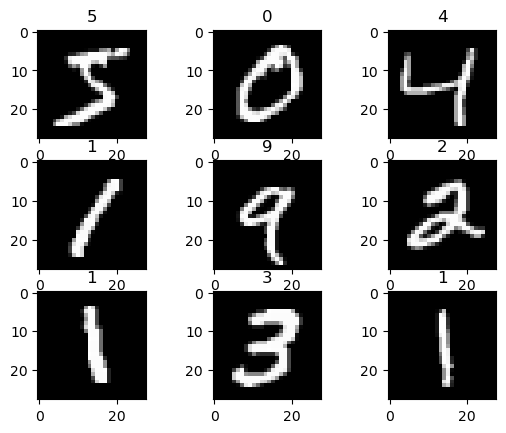

In [123]:
for i in range(9):
  subplot = plt.subplot(330 + 1 + i)
  subplot.set_title(train_y[i])
  plt.imshow(train_X[i], cmap='gray')
plt.show()

# Reshape the data

Before we can create a model and train it, we have to do some preprocessing of the data. I will create a function that takes in the train features and labels as well as the test features and labels. The function will then process the data and return the finished processed data. I will then call this function after I have split the data into 3 groups

In [124]:
train_X = np.array(train_X)
train_y = np.array(train_y)

test_X = np.array(test_X)
test_y = np.array(test_y)

train_X = train_X.reshape(-1, 28, 28, 1)
test_X = test_X.reshape(-1, 28, 28, 1)

train_X = train_X / 255.0
test_X = test_X / 255.0

  - Firstly I convert the current sets into np.arrays as these are easier to work with.
  - Next I convert the numbers into floating decimals
  - Now I want to normalize the data and since each pixel is represented by a value between 0 and 255, I can divid each pixel by 255 to get a number between 0 and 1

Heres how the data looks like after the reshaping:

In [125]:
print("First image:")
print(train_X[0])

print("Corresponding label:")
print(train_y[0])

First image:
[[[0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]]

 [[0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]]

 [[0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.   

## Splitting the data

We were tasked to split the data into 3 local section, create a model for each section, and then aggregate the models into 1 global section with one model. We then want to create a global model directly and compare them.

I split the data into the following sections:
 - All digits between 0 and 2
 - All digits between 3 and 5
 - All digits between 6 and 9

To split the data into three local section, I loop through all examples and check the labels. Depending on the label i put them in different arrays.

In [126]:
train_X_group_one = []
train_y_group_one = []

train_X_group_two = []
train_y_group_two = []

train_X_group_three = []
train_y_group_three = []

for i in range(len(train_X)):
  label = train_y[i]
  if label <= 2:
    train_X_group_one.append(train_X[i])
    train_y_group_one.append(train_y[i])
  elif 3 <= label <= 5:
    train_X_group_two.append(train_X[i])
    train_y_group_two.append(train_y[i] % 3)
  else:
    train_X_group_three.append(train_X[i])
    train_y_group_three.append(train_y[i] % 4)

Because we split the train data, we also need to split the test data so that when we are validating the model we only test it on the same type of data it's train on. E.g. it would give a false result if we were to test a model that was train on only 0, 1s and 2s with pictures of 5s.

In [127]:
test_X_group_one = []
test_y_group_one = []

test_X_group_two = []
test_y_group_two = []

test_X_group_three = []
test_y_group_three = []

for i in range(len(test_X)):
  label = test_y[i]
  if label <= 2:
    test_X_group_one.append(test_X[i])
    test_y_group_one.append(test_y[i])
  elif 3 <= label <= 5:
    test_X_group_two.append(test_X[i])
    test_y_group_two.append(test_y[i] % 3)
  else:
    test_X_group_three.append(test_X[i])
    test_y_group_three.append(test_y[i] % 4)

Now lets make sure all the new arrays we created are np.arrays with the right shape

In [128]:
train_X_group_one = np.array(train_X_group_one).reshape(-1, 28, 28, 1)
train_y_group_one = np.array(train_y_group_one)

train_X_group_two = np.array(train_X_group_two).reshape(-1, 28, 28, 1)
train_y_group_two = np.array(train_y_group_two)

train_X_group_three = np.array(train_X_group_three).reshape(-1, 28, 28, 1)
train_y_group_three = np.array(train_y_group_three)

test_X_group_one = np.array(test_X_group_one).reshape(-1, 28, 28, 1)
test_y_group_one = np.array(test_y_group_one)

test_X_group_two = np.array(test_X_group_two).reshape(-1, 28, 28, 1)
test_y_group_two = np.array(test_y_group_two)

test_X_group_three = np.array(test_X_group_three).reshape(-1, 28, 28, 1)
test_y_group_three = np.array(test_y_group_three)

## Create the model / Train / Test

Now that we are done with processing the data, we can finally start creating the model. Let's create the model for the first group:

In [129]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation=tf.nn.relu))
model.add(tf.keras.layers.Dense(64, activation=tf.nn.relu))
model.add(tf.keras.layers.Dense(3, activation=tf.nn.softmax))

model.compile(
  optimizer='adam',
  loss='sparse_categorical_crossentropy',
  metrics=['accuracy'])

Now that we have a model, we can train it and then finally test it to see the result:

In [130]:
history_group_one = model.fit(train_X_group_one, train_y_group_one, epochs=3, validation_split=0.2)

Train on 14898 samples, validate on 3725 samples
Epoch 1/3
14898/14898 [==============================] - 3s 226us/sample - loss: 0.0642 - accuracy: 0.9813 - val_loss: 0.0205 - val_accuracy: 0.9936
Epoch 2/3
14898/14898 [==============================] - 2s 147us/sample - loss: 0.0211 - accuracy: 0.9936 - val_loss: 0.0138 - val_accuracy: 0.9941
Epoch 3/3
14898/14898 [==============================] - 2s 155us/sample - loss: 0.0120 - accuracy: 0.9965 - val_loss: 0.0187 - val_accuracy: 0.9936


The result is pretty good, but this is only during the train phase. To make sure it's not overfitted we have to test it we a new set of data that is has never been shown to the model:

In [131]:
score_group_one = model.evaluate(test_X_group_one, test_y_group_one)
print('Test accuracy:', score_group_one[1])

pred_group_one = model.predict(test_X_group_one)

3147/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

The accuracy during testing is almost the same as in training, (a tiny bit less, but that's expected). This means that the model we created is pretty good.

Now this is only for the first local section (images with number 0-2), so we have to do this for the two other local section as well:

In [132]:
model2 = tf.keras.models.Sequential()
model2.add(tf.keras.layers.Flatten())
model2.add(tf.keras.layers.Dense(128, activation=tf.nn.relu))
model2.add(tf.keras.layers.Dense(64, activation=tf.nn.relu))
model2.add(tf.keras.layers.Dense(3, activation=tf.nn.softmax))

model2.compile(
  optimizer='adam',
  loss='sparse_categorical_crossentropy',
  metrics=['accuracy'])

In [133]:
history_group_two = model2.fit(train_X_group_two, train_y_group_two, epochs=3, validation_split=0.2)

Train on 13915 samples, validate on 3479 samples
Epoch 1/3
13915/13915 [==============================] - 4s 275us/sample - loss: 0.1118 - accuracy: 0.9610 - val_loss: 0.0633 - val_accuracy: 0.9764
Epoch 2/3
13915/13915 [==============================] - 2s 168us/sample - loss: 0.0368 - accuracy: 0.9882 - val_loss: 0.0543 - val_accuracy: 0.9836
Epoch 3/3
13915/13915 [==============================] - 2s 165us/sample - loss: 0.0194 - accuracy: 0.9932 - val_loss: 0.0449 - val_accuracy: 0.9859


In [134]:
score_group_two = model2.evaluate(test_X_group_two, test_y_group_two)
print('Test accuracy:', score_group_two[1])

pred_group_two = model.predict(test_X_group_two)

2884/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [135]:
model3 = tf.keras.models.Sequential()
model3.add(tf.keras.layers.Flatten())
model3.add(tf.keras.layers.Dense(128, activation=tf.nn.relu))
model3.add(tf.keras.layers.Dense(64, activation=tf.nn.relu))
model3.add(tf.keras.layers.Dense(4, activation=tf.nn.softmax))

model3.compile(
  optimizer='adam',
  loss='sparse_categorical_crossentropy',
  metrics=['accuracy'])

_Here it's worth to notices that we modifed the output layer, because we no longer want to classify between 3 numbers (0-2 and 3-5 in the first to sections), we want to classify between 4 numbers 6-9 (both 6 and 9 included)_

In [136]:
history_group_three = model3.fit(train_X_group_three, train_y_group_three, epochs=3, validation_split=0.2)

Train on 19186 samples, validate on 4797 samples
Epoch 1/3
19186/19186 [==============================] - 4s 210us/sample - loss: 0.1379 - accuracy: 0.9543 - val_loss: 0.0604 - val_accuracy: 0.9794
Epoch 2/3
19186/19186 [==============================] - 3s 157us/sample - loss: 0.0550 - accuracy: 0.9822 - val_loss: 0.0417 - val_accuracy: 0.9852
Epoch 3/3
19186/19186 [==============================] - 3s 155us/sample - loss: 0.0339 - accuracy: 0.9894 - val_loss: 0.0360 - val_accuracy: 0.9867


In [137]:
score_group_three = model3.evaluate(test_X_group_three, test_y_group_three)
print('Test accuracy:', score_group_three[1])

pred_group_three = model.predict(test_X_group_three)

3969/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

## Global model

Now let's create a global model directly and see if the result is any different

In [138]:
model_global = tf.keras.models.Sequential()
model_global.add(tf.keras.layers.Flatten())
model_global.add(tf.keras.layers.Dense(128, activation=tf.nn.relu))
model_global.add(tf.keras.layers.Dense(64, activation=tf.nn.relu))
model_global.add(tf.keras.layers.Dense(10, activation=tf.nn.softmax))

model_global.compile(
  optimizer='adam',
  loss='sparse_categorical_crossentropy',
  metrics=['accuracy'])

_Here we need to specify that we can expect 10 different classification. Therefore the last layers contains 10 neurons_

Let's train this global model

In [139]:
history_global = model_global.fit(train_X, train_y, epochs=3, validation_split=0.2)

Train on 48000 samples, validate on 12000 samples
Epoch 1/3
48000/48000 [==============================] - 8s 167us/sample - loss: 0.2674 - accuracy: 0.9226 - val_loss: 0.1410 - val_accuracy: 0.9573
Epoch 2/3
48000/48000 [==============================] - 7s 153us/sample - loss: 0.1108 - accuracy: 0.9663 - val_loss: 0.1041 - val_accuracy: 0.9666
Epoch 3/3
48000/48000 [==============================] - 7s 154us/sample - loss: 0.0755 - accuracy: 0.9766 - val_loss: 0.0994 - val_accuracy: 0.9707


As you can see, the global model manage to get a pretty good acuracy during training. However it's less then all the other local models above by about 1.5-2%

Let's evalute the global model to see how good it generalized.

In [140]:
score_global = model_global.evaluate(test_X, test_y)
print('Test accuracy:', score_global[1])

pred_global = model_global.predict(test_X)

10000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

The test accuracy was close to the train accuracy, so it did not overfit. Still this test accuray is lower than all of the test accuracies from the local models.

We can create a confusion matrix for the global model, to see how many it got right and how many it got wrong:

<Figure size 640x480 with 0 Axes>

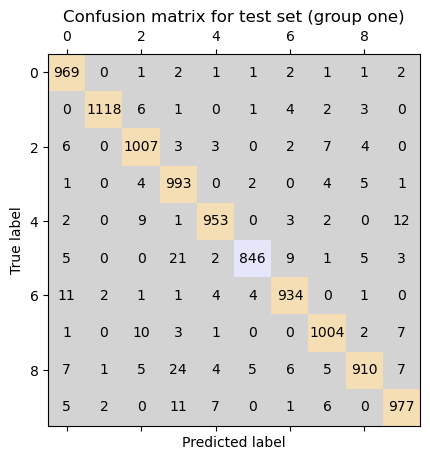

In [141]:
from matplotlib.colors import ListedColormap
from sklearn.metrics import confusion_matrix

cmap = ListedColormap(['lightgrey', 'silver', 'ghostwhite', 'lavender', 'wheat'])

cm = confusion_matrix(test_y, pred_global.argmax(axis=1))
plt.figure()
plt.matshow(cm, cmap=cmap)

for i in range(cm.shape[0]):
  for j in range(cm.shape[1]):
    plt.text(x=j, y=i, s=cm[i, j], va='center', ha='center')

plt.title('Confusion matrix for test set (group one)')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

As we can see, most of the predictions where classified right (as we expect with a accuracy of 97%)